# Is climate in Uruguay becoming Tropical?
## Intro
First of all, why am I doing this?
There's an affirmation that I hear a lot lately and it is that the cliamte in Uruguay is shifting from **Temperate** to **Tropical**. But, is it really happening?

To answer that question, first we need to understand what the different climates are, right?

For that, we use the Köppen clasification that is one of the most used around the world. It categorizes climates based on average monthly and annual temperatures, precipitation, and the seasonality of precipitation.

According to that variables, the climate in Uruguay is **Cfa** meaning it's *Temperate* (C) with *no dry season* (f) and *with hot summer* (a). That's because the coldest month averages above 0 °C, at least one month's average temperature above 22 °C, and at least four months averaging above 10 °C. Besides there is no significant precipitation difference between seasons and there is no dry months in the summer.

For a climate to be considered *Tropical* (A), it needs to have an average temperature of 18 °C or higher every month of the year, with significant precipitation.

With that in mind, my goal is to compare historic climate data with 2023 data to see how that variables evolved over time. Since I'm trying to learn new tools and gain experience in the world of data analytics, I will simplify a lot the study, focusing only on the data from Montevideo stations and considering only min. and max. temperatures, because those are the variables that affect the most the categorization. If you have real interest in how the climate of Uruguay is doing, I can recommend a couple of studies from [INUMET](https://www.inumet.gub.uy/clima/climatologia-estacional) and [FCIEN](https://www.ambiente.gub.uy/oan/documentos/Producto-2.pdf)




## Data Scraping

A data analysis needs data. And where can you find data? On the internet. The obvious place to look for Uruguay's climate data is the INUMET website for it is the official meteorological service of the country.

I've never done a web scraping before, so it was a great opportunity to learn a new skill and tools such as *google colab notebooks* and *python*.


### INUMET Scraping

INUMET presents 3 different tabs, one for each period (**1961 to 1990**, **1981 to 2010** and **1991 to 2020**). Inside each tab, there is a table per weather station. In the period from 1961 to 1990, we have 12 weather stations, in 1981 to 2010, 17 weather stations and in 1991 to 2020 there are 16 weather stations. So in total there are 45 tables to scrap.

In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import json
import os
import numpy as np

In [ ]:
url = "https://www.inumet.gub.uy/clima/estadisticas-climatologicas/tablas-estadisticas"
page = requests.get(url)

# Use BeautifulSoup to parse the HTML content of the webpage stored in 'page.text'
soup = BeautifulSoup(page.text, "html")

In [ ]:
# Find all <ul> elements with class "contTablaEstCli2" in the HTML
table = soup.find_all("ul", class_ = "contTablaEstCli2")

In [ ]:
# Initialize an empty list to store the results
dataframes_list = []

In [ ]:
for ul in table:
  colNames = ul.find("ul")
  colNames_Table = [Name.text.strip() for Name in colNames]

  # The while function removes the empty strings from the list
  while("" in colNames_Table):
    colNames_Table.remove("")

  # We add the "PARAMETER" column so we have the same amount of items in the list as the data rows which contain not only the values but also what those values are (TMED, PP, TMIN)
  colNames_Table.insert(0, "PARAMETER")

  # Now, instead of getting only the first "ul", we are getting everything but the first [1:]
  data = ul.find_all("ul")[1:]
  data_Table = [row.text.strip() for row in data]

  # Splitting each item into a list of lines
  split_data = [item.split("\n") for item in data_Table]

  # We create the dataframe with the data and the column names
  df = pd.DataFrame(split_data, columns = colNames_Table)

  # This will create a list results containing the dataframes generated in each iteration of the loop.
  dataframes_list.append(df)

In [ ]:
# List of all the weather stations
estMet = soup.find_all("ul", class_ = "barraMenu barraDepEstClima fixBM1")

extracted_estMetNames = [estName.text for estName in estMet]

split_estMetNames = [item.split("\n") for item in extracted_estMetNames]

# This code iterates over each sublist in the data list, removes any empty strings using a list comprehension, and stores the cleaned sublists in the cleaned_estMetNames list.
cleaned_estMetNames = [[item for item in sublist if item != ''] for sublist in split_estMetNames]

# Merge sublists into one single list
merged_list = sum(cleaned_estMetNames, [])


### WUnderground Scraping

We got the historical data from INUMET but I couldn't find a complete table with 2023's data. So, I needed to look for it on other sites. WUnderground had the most complete data but in this case we'll have a different approach because the way that WUnderground shows the data is dynamic, meaning that the site makes a request to a javascript to load the data.

The first step was to find the script responsible of that task and using [Postman](https://www.postman.com/) we generated the .json files used here. There is one file per month containing an hour by hour report for each day, so we'll have to clean and process the data later.

The URLs used to get the .json files look like this:

```
https://api.weather.com/v1/location/SUMU:9:UY/observations/historical.json?[API KEY]startDate=20230101&endDate=20230131
```
By changing the *startDate* and the *endDate*, we can tell Postman the range of the data we need. Remember to go month by month, otherwise it won't work.


In [ ]:
def load_json_files(directory):
    data = {}
    file_count = 0
    files = os.listdir(directory)
    for filename in files:
        if filename.endswith(".json"):
            with open(os.path.join(directory, filename), "r") as file:
                json_data = json.load(file)
                for key, value in json_data.items():
                    data.setdefault(key, []).extend(value)
                file_count += 1
    return data, file_count

# Path to the directory where the JSON files are located in Google Drive
directory_path = "/content/drive/MyDrive/json"
merged_data, num_files_loaded = load_json_files(directory_path)

### INUMET Data processing

Now that we have our dataframe, we can start to process it to get what we need for the analysis. The first column *PARAMETER* is the one that tell us what we are measuring. In this study, the parameter we are going to use is *TMED* because it's the mean temparature for each month.

The *PER* column is the period when the data was colected, then we have a column for each month, one resuming the anual values and last we will create a column "EST_METEO" where we are going to store the weather station once all the tables are combined.

In [ ]:
# Loop over each DataFrame in the dataframes_list
for i, df in enumerate(dataframes_list):
    # Add a new column called "EST_METEO" and fill it with values from station_list
    df['EST_METEO'] = merged_list[i % len(merged_list)]

In [ ]:
# This will concatenate all the dataframes in the results list into a single dataframe called combined_df, where ignore_index=True ensures that the resulting dataframe has a new index that is continuous across all rows.
combined_df = pd.concat(dataframes_list, ignore_index=True)

In [ ]:
# Filter only Montevideo Stations.
filtered_df = combined_df[(combined_df['EST_METEO'] == 'Prado') | (combined_df['EST_METEO'] == 'Carrasco')]

In [ ]:
filtered_df.reset_index(drop=True, inplace=True)
tmed_df = filtered_df[filtered_df['PARAMETER'] == 'TMED'].copy()

tmed_df

,PARAMETER,PER,ENE,FEB,MAR,ABR,MAY,JUN,JUL,AGO,SET,OCT,NOV,DIC,ANUAL,EST_METEO
0,TMED,61-90,"22,7","22,3","20,5","17,2","13,9",11,"10,7","11,5","13,2","15,7","18,3","21,1","16,5",Carrasco
12,TMED,61-90,23,"22,5","20,6","17,2",14,"11,1","10,9","11,7","13,4",16,"18,6","21,3","16,7",Prado
24,TMED,81-2010,"22,6","22,2","20,7","17,3","14,0","11,2","10,5","11,9","13,2","16,0","18,4","20,9","16,6",Carrasco
31,TMED,81-2010,"23,3","22,7","21,2","17,7","14,4","11,6","10,9","12,4","13,7","16,5","19,1","21,5","17,1",Prado
38,TMED,91-2020,"22,6","22,3","20,8","17,7","14,4","11,5","10,6","12,1","13,4","16,0","18,6","21,2","16,8",Carrasco
45,TMED,91-2020,"23,3","22,8","21,2","18,1","14,8","11,9","11,0","12,6","13,9","16,5","19,2","21,8","17,3",Prado


In [ ]:
# Now, export the merged DataFrame to a CSV file. Not really necessary but I like to have a backup.
tmed_df.to_csv('datosINUMET.csv', index=False)

### WUnderground Data processing

Processing this data looks easier. We just need to delete the metadata part of the .json files and choose the columns we are going to use. In this case these would be the name of the weather station (*obs_name*), the record time (*valid_time_gmt*) and the temperature (*temp*). Since the time is in UNIX format we have to make an extra step and convert it to a more *human* format. By doing so, we are now able to split the date into Year, Month, Day and Hour and then we can group our table in a more suitable way to work with.

In [ ]:
# Check if 'metadata' key exists
if 'metadata' in merged_data:
    # Remove 'metadata' key
    del merged_data['metadata']

In [ ]:
# Define the keys you want to include in the DataFrame
keys_to_include = ['obs_name', 'valid_time_gmt', 'temp']

# Create a dictionary containing only the selected keys
filtered_data = [{key: item[key] for key in keys_to_include} for item in merged_data['observations']]

# Create a DataFrame from the filtered data
df = pd.DataFrame(filtered_data)

In [ ]:
# Convert Unix timestamp to pandas datetime and adjust for GMT-3 timezone

#df['valid_time_gmt'] = pd.to_datetime(df['valid_time_gmt'], unit='s', utc=True).dt.tz_convert('America/Sao_Paulo').dt.strftime('%Y/%m/%d %H:%M:%S')
df['valid_time_gmt'] = pd.to_datetime(df['valid_time_gmt'], unit='s') + pd.to_timedelta(-3, unit='h')

In [ ]:
df['Year'] = df['valid_time_gmt'].dt.year
df['Month'] = df['valid_time_gmt'].dt.month
df['Day'] = df['valid_time_gmt'].dt.day
df['Hour'] = df['valid_time_gmt'].dt.hour

In [ ]:
# Group by day and calculate the minimum and maximum temperature for each day
daily_temps = df.groupby(['Year', 'Month', 'Day']).agg({'temp': ['min', 'max']})

# Flatten multi-level column index
daily_temps.columns = ['TMIN', 'TMAX']

# Reset index to make 'Year', 'Month', and 'Day' columns instead of an index
daily_temps.reset_index(inplace=True)

# Group by month and calculate the average of the minimum and maximum temperature for each month
monthly_avg_temps = daily_temps.groupby(['Year', 'Month']).agg({'TMIN': 'mean', 'TMAX': 'mean'})

# Reset index to make 'Year' and 'Month' columns instead of an index
monthly_avg_temps.reset_index(inplace=True)

# Now you have a DataFrame with one row per month, with columns for average TMIN and TMAX
monthly_avg_temps

,Year,Month,TMIN,TMAX
0,2023,1,18.870968,28.806452
1,2023,2,18.750000,28.678571
2,2023,3,19.935484,28.516129
3,2023,4,13.366667,22.033333
4,2023,5,11.354839,19.580645
5,2023,6,7.700000,16.466667
6,2023,7,8.967742,16.516129
7,2023,8,7.096774,18.129032
8,2023,9,10.300000,17.700000
9,2023,10,10.838710,20.161290


In [ ]:
monthly_avg_temps.to_csv('datosWU_Mensuales.csv', index=False)


## Data Analysis
I intended to do the analysis using the Python library *Matplotlib*, but to be honest I didn't like how the charts look. How did I do the analysis then? Well, my first attempt was Tableau but I ended up using PowerBi because I felt more comfortable with it. I'm not saying I don't like Tableau at all, just that since I've already learned a lot during this *"study"*, I gave my brain a rest for a while.

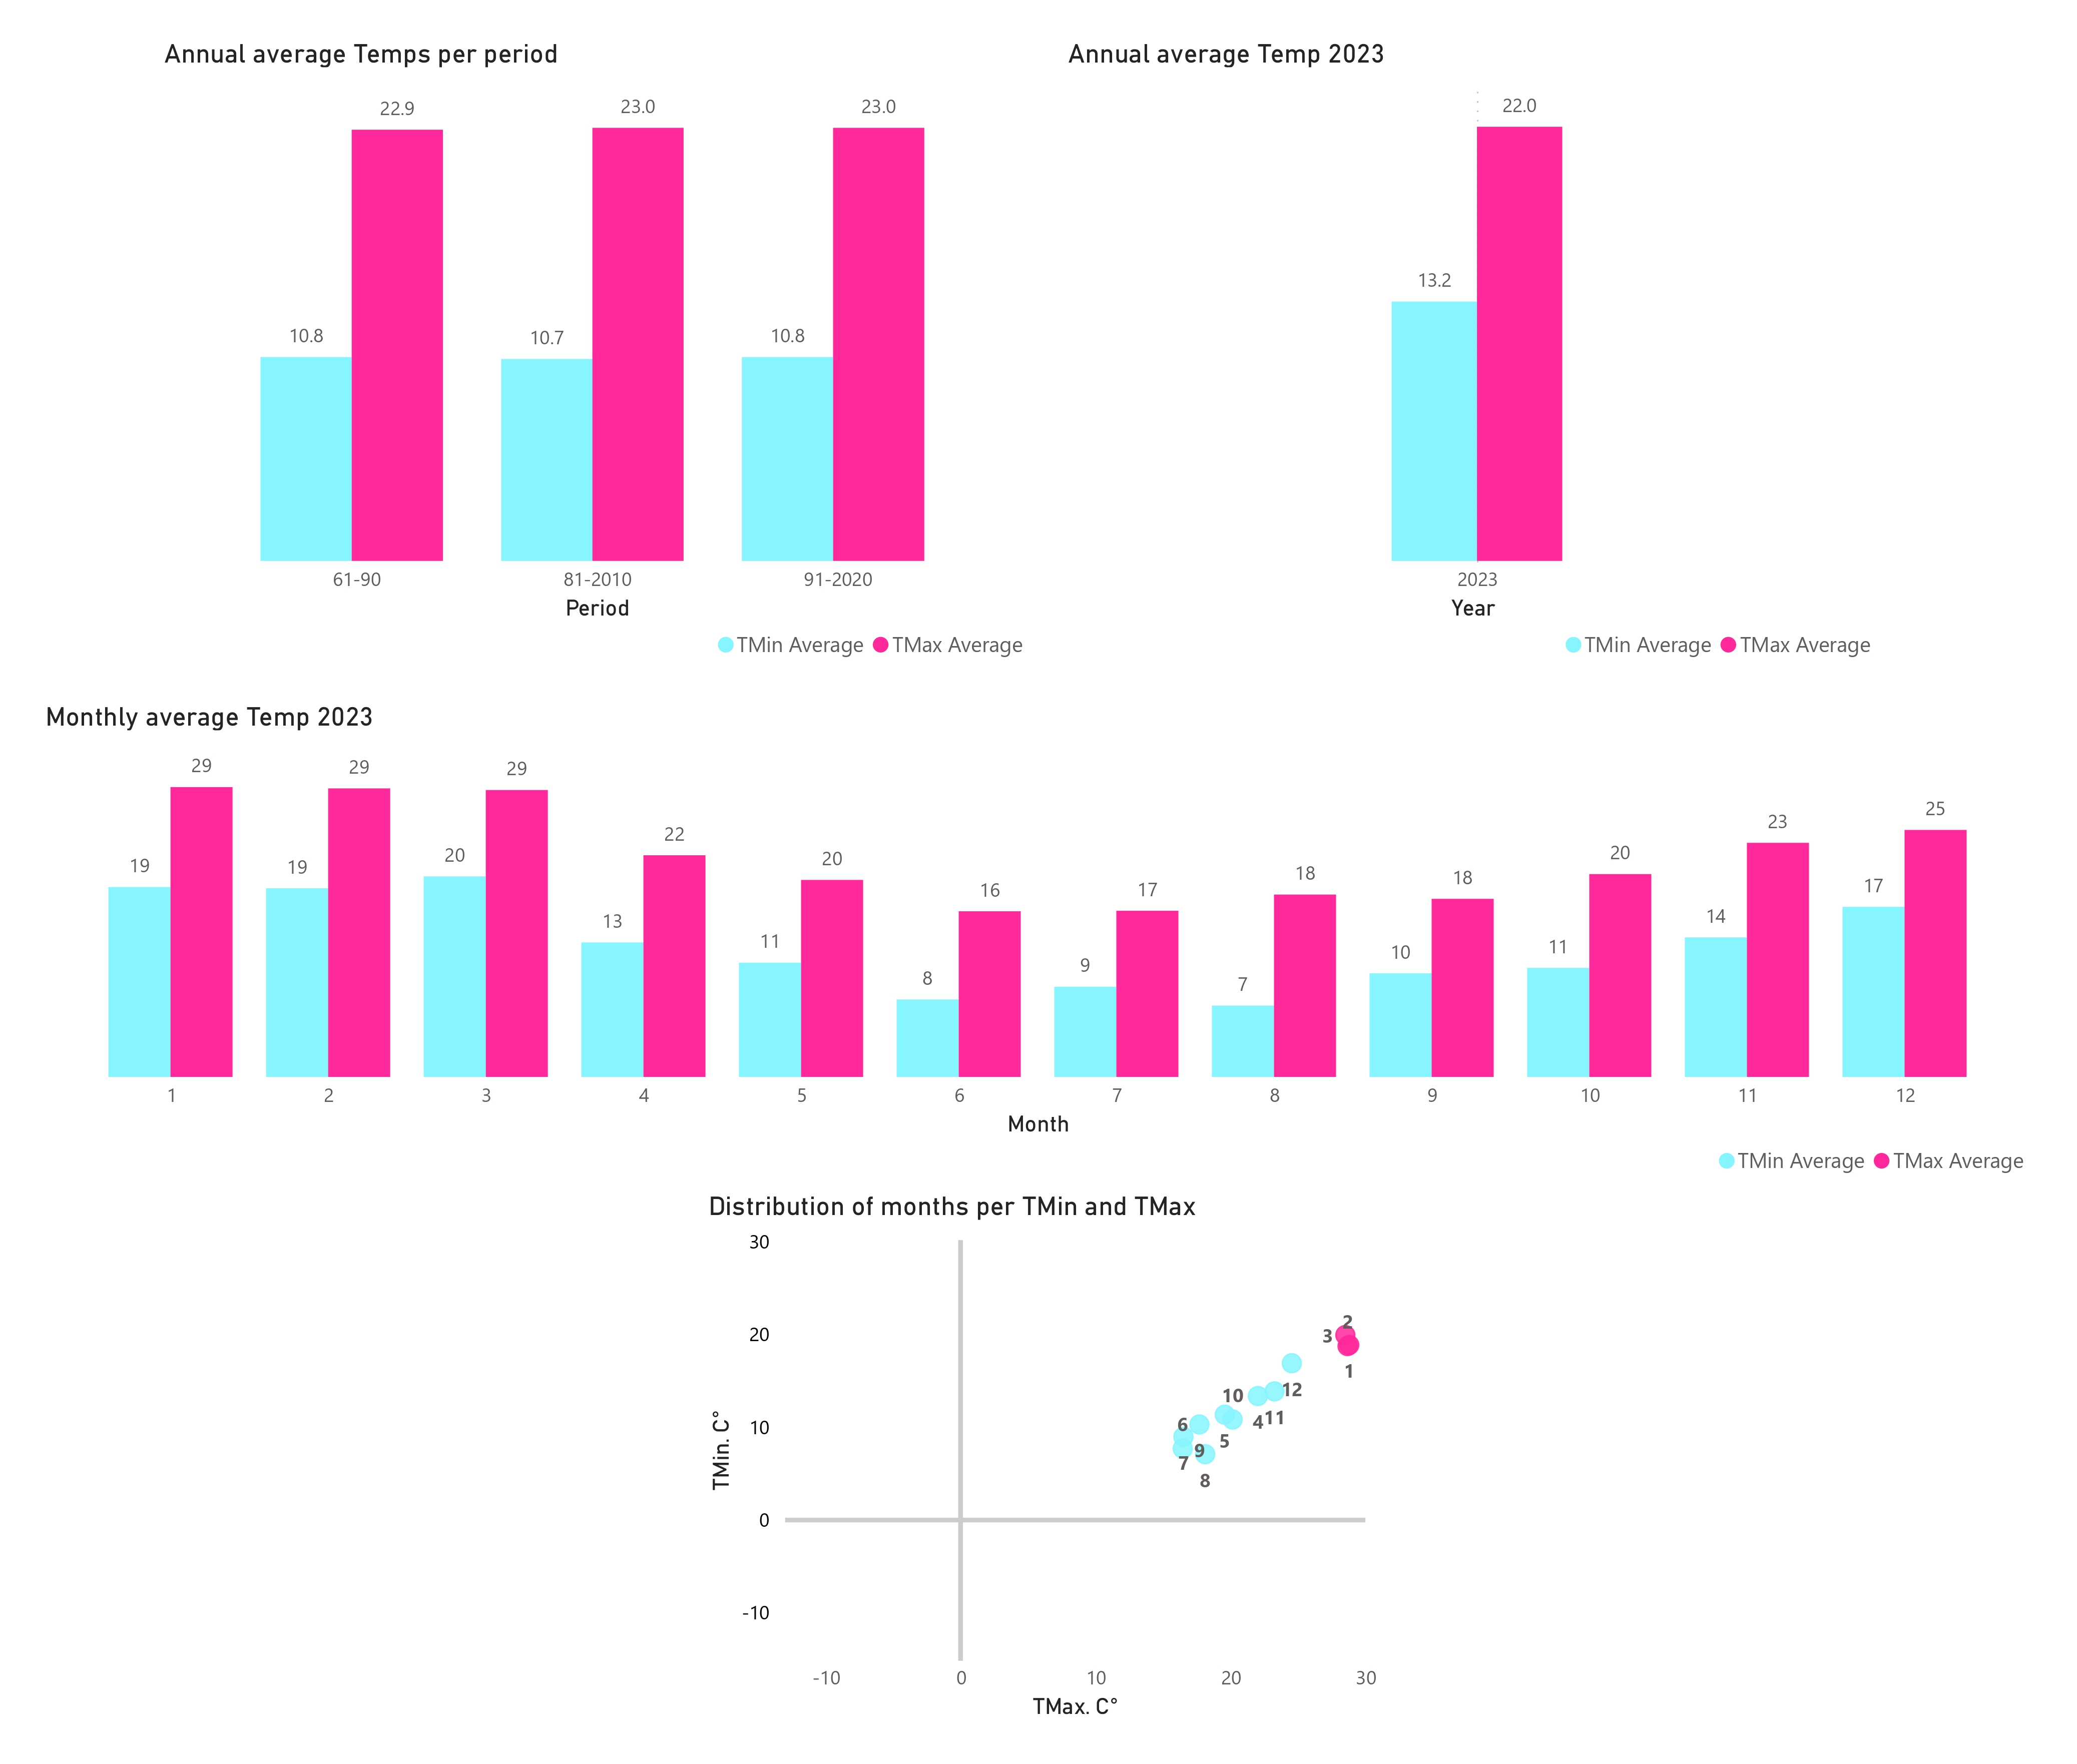

## Conclusion and Next Steps

The short answer to the question is **NO**, we are not shifting to a tropical climate.

But let's not just stay on the surface and dive a bit deeper.

We can appreciate that min. and max. temperatures throughout the different periods stayed practically unaltered, meaning that there wasn't any particular shift towards a tropical climate (or any type of climate at all). However, if we focus on 2023's data, the min. temperature suffered a big leap (+2.5°C) compared to the 3 periods while the max. temperature dropped by 1°C.

Although we cannot say that the climate in Uruguay as a whole is shifting to a tropical climate, we can definitley say that January, Febraury and March of 2023 were Tropical since the average min. temperature was above 18°C. But we need to take into account the precipitation too, and now that I think about it better, there was a massive drought during those months, so technically they would be categorized as **Arid** not tropical because there were no rain at all.

A further investigation would be necessary to try to understand why the min. temperature was so high in 2023. Multiple factors could have caused it, for example the transition from **La Niña** to **El Niño** or the solar activity and its peak of the 11 year cycle. It would also be of great help understanding what happend in other similar near regions for example south of Brazil and east of Argentina.